In [26]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import add_dummy_feature

warnings.filterwarnings('ignore')

#### data load

In [27]:
# 파일 호출
data_path: str = "../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [28]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 36.93it/s]


#### EDA

In [29]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_liquidations_okex_btc_usdt_long_liquidations                 100.0
hourly_market-data_liquidations_okex_btc_usdt_short_liquidations                100.0
hourly_market-data_liquidations_okex_btc_usdt_long_liquidations_usd             100.0
hourly_market-data_open-interest_kraken_open_interest                           100.0
hourly_market-data_liquidations_ftx_all_symbol_long_liquidations                100.0
                                                                                ...  
hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations          0.0
hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd       0.0
hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd      0.0
target                                                                            0.0
ID                                                                                0.0
Length: 255, dtype: float64

In [30]:
# 100.0인 값들만 필터링
missing_100_columns = sorted_missing_percentage[sorted_missing_percentage == 100.0].index.tolist()
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
print(len(missing_100_columns), len(non_missing_columns))
print(missing_100_columns)

40 215
['hourly_market-data_liquidations_okex_btc_usdt_long_liquidations', 'hourly_market-data_liquidations_okex_btc_usdt_short_liquidations', 'hourly_market-data_liquidations_okex_btc_usdt_long_liquidations_usd', 'hourly_market-data_open-interest_kraken_open_interest', 'hourly_market-data_liquidations_ftx_all_symbol_long_liquidations', 'hourly_market-data_liquidations_ftx_all_symbol_short_liquidations', 'hourly_market-data_liquidations_ftx_all_symbol_long_liquidations_usd', 'hourly_market-data_open-interest_all_exchange_open_interest', 'hourly_market-data_open-interest_huobi_global_open_interest', 'hourly_market-data_liquidations_okex_all_symbol_long_liquidations', 'hourly_market-data_liquidations_okex_all_symbol_short_liquidations', 'hourly_market-data_liquidations_okex_all_symbol_long_liquidations_usd', 'hourly_market-data_liquidations_okex_all_symbol_short_liquidations_usd', 'hourly_market-data_open-interest_ftx_open_interest', 'hourly_market-data_open-interest_okex_open_interest',

##### network data

In [31]:
network_columns = [column for column in non_missing_columns if 'network' in column]

# network data corrrelation
network_corr = eda_df[network_columns].corr()
corr_matrix = network_corr.where(np.triu(np.ones(network_corr.shape), k=1).astype(bool))
corr_pairs = corr_matrix.stack()
corr_pairs = corr_pairs.abs().sort_values(ascending=False)
corr_pairs

hourly_network-data_block-count_block_count                 hourly_network-data_supply_supply_new                             1.000000
hourly_network-data_fees_fees_block_mean_usd                hourly_network-data_fees_fees_block_mean                          0.986293
hourly_network-data_supply_supply_total                     hourly_network-data_velocity_velocity_supply_total                0.984982
hourly_network-data_fees-transaction_fees_transaction_mean  hourly_network-data_fees-transaction_fees_transaction_mean_usd    0.982914
hourly_network-data_fees_fees_total                         hourly_network-data_fees_fees_total_usd                           0.982144
                                                                                                                                ...   
hourly_network-data_block-interval_block_interval           hourly_network-data_supply_supply_total                           0.006033
hourly_network-data_block-bytes_block_bytes            

In [32]:
# 상수항 추가 (VIF 계산 시 필요)
df = eda_df[network_columns]
df = df.fillna(method='ffill')

# VIF 계산 함수
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    
    # VIF 계산
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# VIF 값 계산
vif_data = calculate_vif(df)
vif_data.sort_values(by="VIF", ascending=False, inplace=True)

In [33]:
# VIF 10을 초과하는 컬럼 필터링
high_vif = vif_data[vif_data["VIF"] > 10]

# 상관관계 계산
correlations = df.corr()

# VIF 10 이상인 컬럼 간 상관관계 및 VIF 값으로 새로운 데이터프레임 생성
results = []

# VIF 10 이상인 각 컬럼에 대해 상관관계와 VIF 값 추출
for i, col1 in enumerate(high_vif['Feature']):
    for col2 in high_vif['Feature'][i+1:]:
        corr_value = correlations.loc[col1, col2]
        vif_value1 = high_vif[high_vif['Feature'] == col1]['VIF'].values[0]
        vif_value2 = high_vif[high_vif['Feature'] == col2]['VIF'].values[0]
        results.append({'Column1': f'{col1}', 'Column2' : f'{col2}', 'Correlation': corr_value, 'VIF': max(vif_value1, vif_value2)})

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(results)
result_df.head(10)

,Column1,Column2,Correlation,VIF
0,hourly_network-data_block-count_block_count,hourly_network-data_blockreward_blockreward,0.965817,3.980104e+07
1,hourly_network-data_block-count_block_count,hourly_network-data_supply_supply_new,1.000000,3.980104e+07
2,hourly_network-data_block-count_block_count,hourly_network-data_fees_fees_total,0.160264,3.980104e+07
3,hourly_network-data_block-count_block_count,hourly_network-data_addresses-count_addresses_...,0.839558,3.980104e+07
4,hourly_network-data_block-count_block_count,hourly_network-data_addresses-count_addresses_...,0.874963,3.980104e+07
5,hourly_network-data_block-count_block_count,hourly_network-data_fees_fees_block_mean_usd,-0.072917,3.980104e+07
6,hourly_network-data_block-count_block_count,hourly_network-data_fees_fees_block_mean,-0.086751,3.980104e+07
7,hourly_network-data_block-count_block_count,hourly_network-data_fees_fees_total_usd,0.142083,3.980104e+07
8,hourly_network-data_block-count_block_count,hourly_network-data_fees-transaction_fees_tran...,-0.092175,3.980104e+07
9,hourly_network-data_block-count_block_count,hourly_network-data_fees-transaction_fees_tran...,-0.097589,3.980104e+07


**insight**
1. hourly_network-data_block-count_block_count (주어진 시간대에 생성된 블록의 수)와 VIF(다중공선성 값)이 높은 변수들이 많이 있음 -> 제거하는 방향으로 가도 좋을듯?  
: 해당 변수의 값과 target과의 관계를 파악해서 유의미한 변수라면 해당 변수만을 남겨도 되지 않을까?

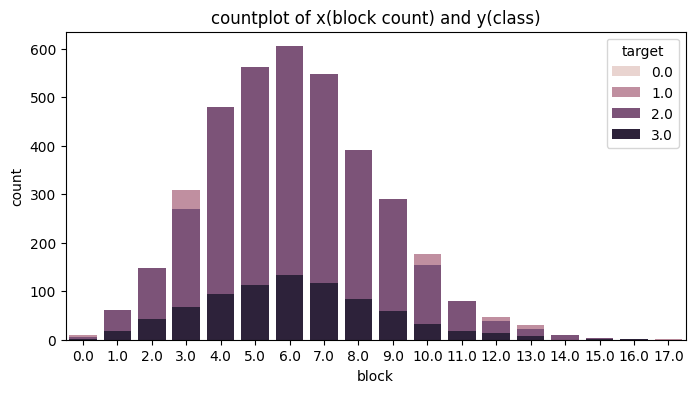

In [34]:
block_count_df = eda_df[['hourly_network-data_block-count_block_count','target']]

plt.figure(figsize = (8,4))
sns.countplot(x = 'hourly_network-data_block-count_block_count', hue = 'target', data = block_count_df, dodge=False)
plt.title('countplot of x(block count) and y(class)')
plt.xlabel('block')
plt.ylabel('count')
plt.show()

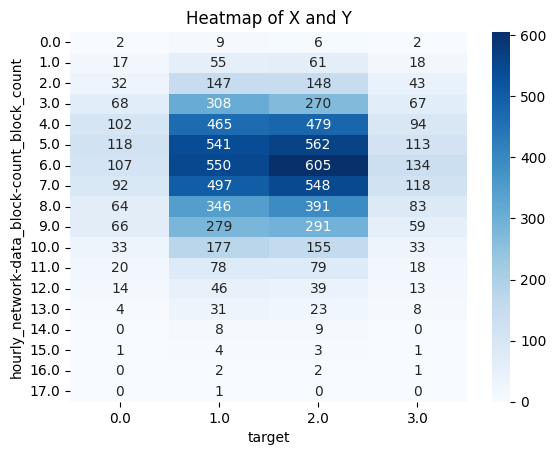

In [35]:
crosstab = pd.crosstab(block_count_df['hourly_network-data_block-count_block_count'], block_count_df['target'])
sns.heatmap(crosstab, annot=True, cmap='Blues', fmt='d')
plt.title('Heatmap of X and Y')
plt.show()

**insight**  
각각의 class에 대해 동일한 분포를 보이고 있으며 정규분포를 만족하고 있다. class에 따라, 그리고 block의 수에 따라 특정한 관계를 보이고 있진 않아보인다.  
그렇다면 해당 변수와 관련된 다른 변수와의 관계와 그 변수와 target과의 관계를 시각화화여 특징분석을 진행해보자.

In [36]:
# 가장 높은 VIF를 가지면서 높은 correlation(1.00)을 가진 network column
# hourly_network-data_supply_supply_new (새로 발행된 코인의 총합) - counting variable
col_high_df = eda_df[['hourly_network-data_block-count_block_count','hourly_network-data_supply_supply_new','target']]

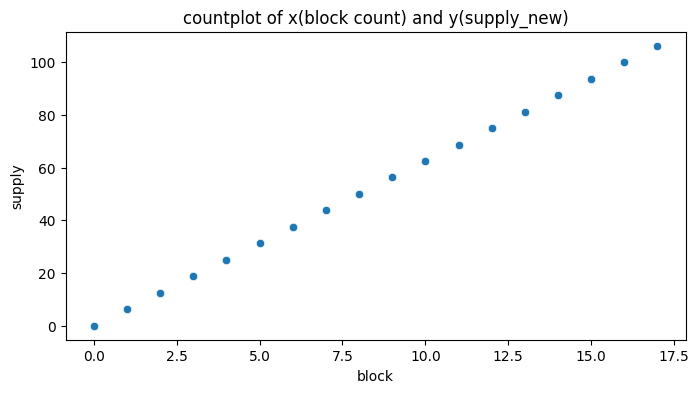

In [37]:
plt.figure(figsize = (8,4))
sns.scatterplot(x = 'hourly_network-data_block-count_block_count', y = 'hourly_network-data_supply_supply_new', data = col_high_df)
plt.title('countplot of x(block count) and y(supply_new)')
plt.xlabel('block')
plt.ylabel('supply')
plt.show()

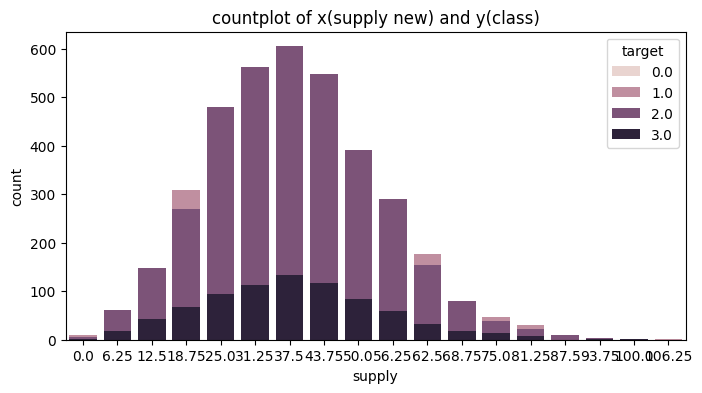

In [38]:
plt.figure(figsize = (8,4))
sns.countplot(x = 'hourly_network-data_supply_supply_new', hue = 'target', data = col_high_df, dodge=False)
plt.title('countplot of x(supply new) and y(class)')
plt.xlabel('supply')
plt.ylabel('count')
plt.show()

In [39]:
bar_df = col_high_df.groupby("target").agg({
    'hourly_network-data_supply_supply_new' : "mean"
}).reset_index()
bar_df # target 별로

,target,hourly_network-data_supply_supply_new
0,0.0,37.668919
1,1.0,38.268905
2,2.0,38.298488
3,3.0,37.965839


In [40]:
# 가장 높은 VIF를 가지면서 낮은 correlation(-0.07)을 가진 network column
# hourly_network-data_fees_fees_block_mean_usd(블록당 평균 수수료(단위 USD)) - continuous variable
col_low_df = eda_df[['hourly_network-data_block-count_block_count','hourly_network-data_fees_fees_block_mean_usd','target']]
col_low_df.head(3)

,hourly_network-data_block-count_block_count,hourly_network-data_fees_fees_block_mean_usd,target
0,12.0,772.625301,2.0
1,4.0,1059.273848,1.0
2,8.0,647.076754,1.0


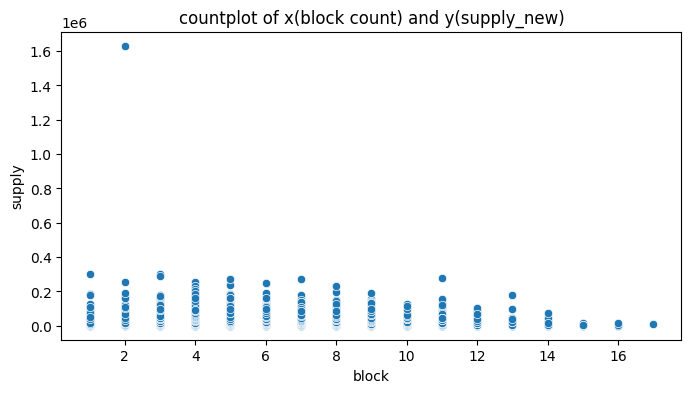

In [41]:
plt.figure(figsize = (8,4))
sns.scatterplot(x = 'hourly_network-data_block-count_block_count', y = 'hourly_network-data_fees_fees_block_mean_usd', data = col_low_df)
plt.title('countplot of x(block count) and y(supply_new)')
plt.xlabel('block')
plt.ylabel('supply')
plt.show()

우선 이상치는 제거하고 다시 분석

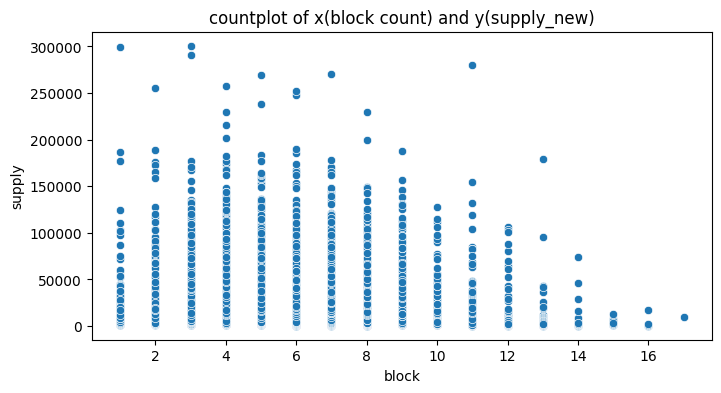

In [42]:
col_low_df_fixed = col_low_df.drop(index = col_low_df[col_low_df['hourly_network-data_fees_fees_block_mean_usd'] == col_low_df['hourly_network-data_fees_fees_block_mean_usd'].max()].index)

plt.figure(figsize = (8,4))
sns.scatterplot(x = 'hourly_network-data_block-count_block_count', y = 'hourly_network-data_fees_fees_block_mean_usd', data = col_low_df_fixed)
plt.title('countplot of x(block count) and y(supply_new)')
plt.xlabel('block')
plt.ylabel('supply')
plt.show()

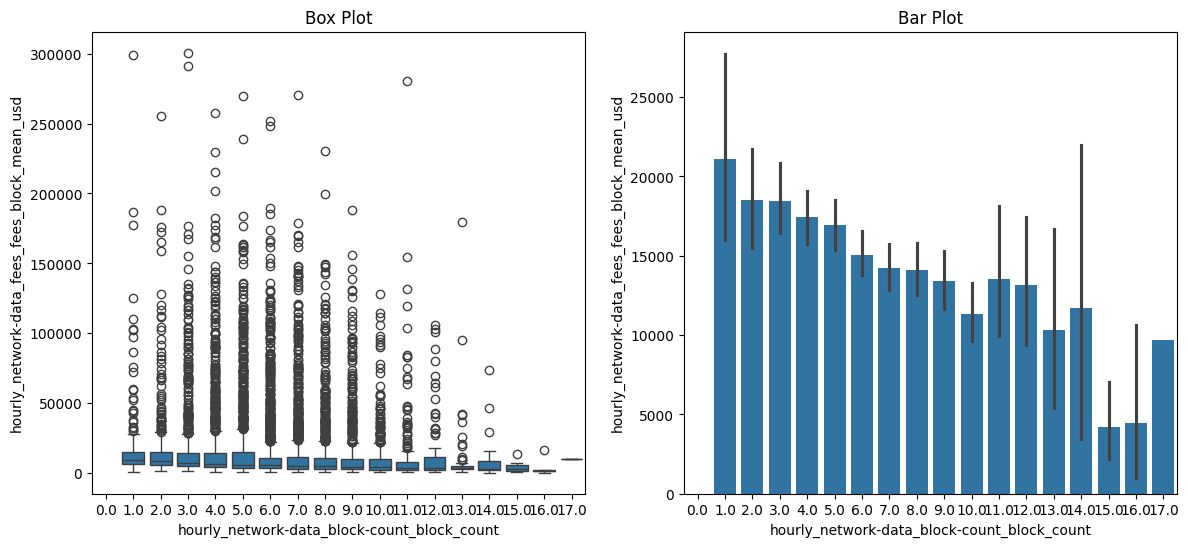

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='hourly_network-data_block-count_block_count', y='hourly_network-data_fees_fees_block_mean_usd', data=col_low_df_fixed, ax=ax[0])
ax[0].set_title('Box Plot')

sns.barplot(x='hourly_network-data_block-count_block_count', y='hourly_network-data_fees_fees_block_mean_usd', data=col_low_df_fixed, estimator='mean', ax=ax[1])
ax[1].set_title('Bar Plot')

plt.show()

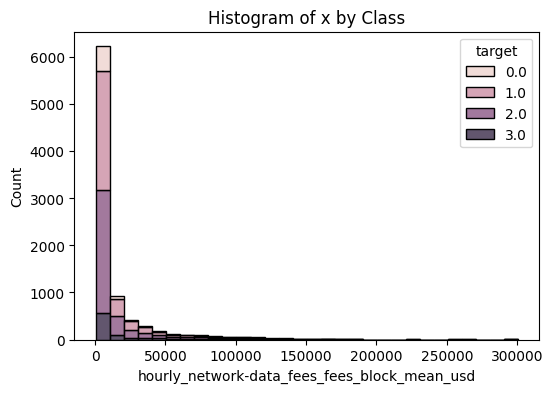

In [44]:
plt.figure(figsize = (6, 4))
sns.histplot(data=col_low_df_fixed, x='hourly_network-data_fees_fees_block_mean_usd', hue='target', multiple='stack', bins=30)
plt.title('Histogram of x by Class')
plt.show()

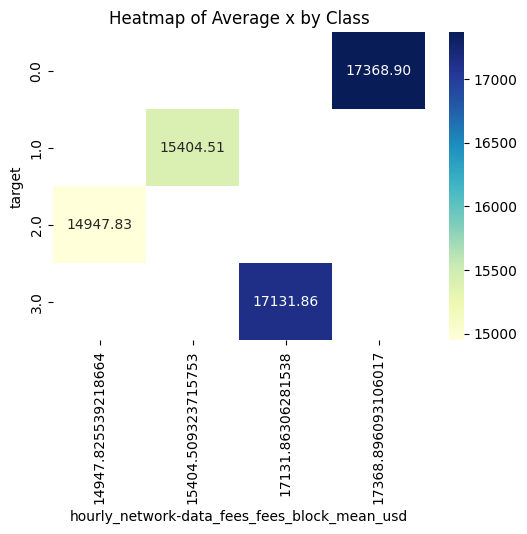

In [45]:
plt.figure(figsize = (6,4))
heatmap_data = col_low_df_fixed.groupby('target')['hourly_network-data_fees_fees_block_mean_usd'].mean().reset_index()
heatmap_data_pivot = heatmap_data.pivot(index='target', columns='hourly_network-data_fees_fees_block_mean_usd', values='hourly_network-data_fees_fees_block_mean_usd')
sns.heatmap(heatmap_data_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Heatmap of Average x by Class')
plt.show()

In [46]:
# hourly_network-data_fees-transaction_fees_transaction_mean 변수와 관련있는 변수 확인
result_df[result_df['Column1'] == 'hourly_network-data_fees-transaction_fees_transaction_mean']

,Column1,Column2,Correlation,VIF
155,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_addresses-count_addresses_...,-0.155973,166.471048
156,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_hashrate_hashrate,0.048676,166.471048
157,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_blockreward_blockreward_usd,0.315595,166.471048
158,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_difficulty_difficulty,0.367648,166.471048
159,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_fees-transaction_fees_tran...,0.982815,166.471048
160,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_fees_fees_reward_percent,0.858723,166.471048
161,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_transactions-count_transac...,0.076543,166.471048
162,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_velocity_velocity_supply_t...,-0.254356,166.471048
163,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_utxo-count_utxo_count,0.322614,166.471048
164,hourly_network-data_fees-transaction_fees_tran...,hourly_network-data_transactions-count_transac...,0.260928,166.471048


In [48]:
bar_df = col_low_df_fixed.groupby("target").agg({
    'hourly_network-data_fees_fees_block_mean_usd' : "mean"
}).reset_index()
bar_df # target 별로

,target,hourly_network-data_fees_fees_block_mean_usd
0,0.0,17368.896093
1,1.0,15404.509324
2,2.0,14947.825539
3,3.0,17131.863063


##### 변수와 target의 관계 확인

In [67]:
def analyze_feature_trends(df, target_column, features):
    results = []
    results_inv = []
    
    # 각 변수에 대해 타겟 클래스 별 평균 계산
    for feature in features:
        data = df[[feature, target_column]]
        bar_df = data.groupby(target_column).agg({feature: "mean"}).reset_index()
        
        is_increasing = bar_df[feature].is_monotonic_increasing
        is_decreasing = bar_df[feature].is_monotonic_decreasing

        if (is_increasing == False) & (is_decreasing == False):
            results_inv.append(feature)
        else:
            results.append(feature)

    return results, results_inv

In [68]:
a, b = analyze_feature_trends(eda_df, "target", network_columns)

In [69]:
print(a)
print(b)

[]
['hourly_network-data_fees-transaction_fees_transaction_mean', 'hourly_network-data_difficulty_difficulty', 'hourly_network-data_transactions-count_transactions_count_mean', 'hourly_network-data_fees_fees_block_mean_usd', 'hourly_network-data_block-interval_block_interval', 'hourly_network-data_fees_fees_block_mean', 'hourly_network-data_block-bytes_block_bytes', 'hourly_network-data_fees_fees_reward_percent', 'hourly_network-data_tokens-transferred_tokens_transferred_mean', 'hourly_network-data_fees-transaction_fees_transaction_mean_usd', 'hourly_network-data_block-count_block_count', 'hourly_network-data_transactions-count_transactions_count_total', 'hourly_network-data_supply_supply_total', 'hourly_network-data_supply_supply_new', 'hourly_network-data_velocity_velocity_supply_total', 'hourly_network-data_utxo-count_utxo_count', 'hourly_network-data_fees-transaction_fees_transaction_median', 'hourly_network-data_fees-transaction_fees_transaction_median_usd', 'hourly_network-data_a

**insight**
선형 관계를 보이는 값은 없다..